In [28]:
%matplotlib inline
from  pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import matplotlib.patches as patches # For bounding boxes
from PIL import Image
from collections import defaultdict
import json
from tqdm import tqdm_notebook
import os 
import urllib.request
import cv2 as cv
import time

plt.rcParams['figure.figsize'] = (15, 15)

In [10]:
# Define paths

dataDir = "COCOdataset2017"
dataValType   = 'val2017'
dataTrainType = 'train2017'
annValFile   ='{}/annotations/instances_{}.json'.format(dataDir,dataValType)
annTrainFile ='{}/annotations/instances_{}.json'.format(dataDir,dataTrainType)

DATA_SOURCE_DIR = "./COCOdataset2017/images"
ANN_DIR   = os.path.join(DATA_SOURCE_DIR, "annotations")
TRAIN_DIR = os.path.join(DATA_SOURCE_DIR, "train")
VAL_DIR   = os.path.join(DATA_SOURCE_DIR, "val")
TEST_DIR  = os.path.join(DATA_SOURCE_DIR, "test")

YOLO_DIR       = "yolo"
YOLO_SETTINGS  = os.path.join(YOLO_DIR, "yolo_settings")
YOLOV3_CFG     = os.path.join(YOLO_SETTINGS, "yolov3.cfg")
YOLOV3_WEIGHTS = os.path.join(YOLO_SETTINGS, "yolov3.weights")

YOLOV4_SETTINGS = os.path.join(YOLO_DIR, "yolo_settings")
YOLOV4_CFG      = os.path.join(YOLO_SETTINGS, "yolov4.cfg")
YOLOV4_WEIGHTS  = os.path.join(YOLO_SETTINGS, "yolov4.weights")

In [30]:
class YoloConfig:
    def __init__(self, yolo_cfg, yolo_weight, subClass=[], conf_threshold=0.5, nms_threshold=0.4,
                 scaleFactor=0.00392, inputImageSize=(416, 416), meanValToSubtract=(0, 0, 0),
                 active_gpu=False):
        # yolo conf
        self.yolo_cfg       = yolo_cfg
        self.yolo_weight    = yolo_weight

        # params of input blob
        self.subClass       = subClass
        self.scaleFactor    = scaleFactor
        self.inputImageSize = inputImageSize
        self.meanValToSubtract = meanValToSubtract

        # params conf of post_processing
        self.conf_threshold = conf_threshold
        self.nms_threshold  = nms_threshold

        self.active_gpu = active_gpu



class objectDetectorYolo:
    def __init__(self, yolo_config : YoloConfig):
        
        self.yolo_config = yolo_config
        self.preds = []
        self.net   = self.load_models(self.yolo_config.active_gpu)

    
    def load_models(self, active_gpu=False):

        net = cv.dnn.readNetFromDarknet(str(self.yolo_config.yolo_cfg), 
                                        str(self.yolo_config.yolo_weight))

        if (self.yolo_config.active_gpu):
            print("set gpu")
            net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
            net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)
        else:
            net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)        

        return net

    def get_ouputs_name(self):
        layer_names = self.net.getLayerNames()
        try:
            ouput_layers = [layer_names[i-1]    for i in self.net.getUnconnectedOutLayers()]
        except:
            ouput_layers = [layer_names[i[0]-1] for i in self.net.getUnconnectedOutLayers()]
        
        return ouput_layers
    
    def post_processing(self, inputImage, img_js, outputs):

        H, W = inputImage.shape[:2]

        boxes       = []
        confidences = []
        classIDs    = []

        for output in outputs:
            scores = output[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > self.yolo_config.conf_threshold:
                x, y, w, h = output[:4] * np.array([W, H, W, H])
                p0 = int(x - w//2), int(y - h//2)
                p1 = int(x + w//2), int(y + h//2)
                boxes.append([*p0, int(w), int(h)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                                    
        indices = cv.dnn.NMSBoxes(boxes, confidences, self.yolo_config.conf_threshold, self.yolo_config.nms_threshold)

        # indicate which boxses should be displayed
        user_indices = np.array([i for i in indices if classes[classIDs[i]] in self.yolo_config.subClass])

        if len(user_indices) > 0:
            for i in user_indices:
                pred = {}

                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                color = [int(c) for c in colors[classIDs[i]]]# Load names of classes and get random colors
                cv.rectangle(inputImage, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
                cv.putText(inputImage, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                
                pred["image_id"]    = img_js["id"]
                pred["category_id"] = classIDs[i] 
                pred["bbox"]        = [x, y, w, h]
                pred["score"]       = confidences[i]
                self.preds.append(pred)

    def get_preds(self):
        return self.preds
    
    def refresh_preds(self):
        self.preds.clear()
    
    def detect_objects(self, img_js, show_detect_image=True):
        
        inputImage = cv.imread(os.path.join(TRAIN_DIR, img_js['file_name']))
        
        t0 = time.time()

        # generate blobs from input image
        inputBlob = cv.dnn.blobFromImage(inputImage,  self.yolo_config.scaleFactor, self.yolo_config.inputImageSize, swapRB=True, crop=False)
        self.net.setInput(inputBlob)

        # set blob into 
        outputs = self.net.forward(self.get_ouputs_name())

        # combine the 3 output groups into 1 (10647, 85)
        # large objects (507, 85)
        # medium objects (2028, 85)
        # small objects (8112, 85)
        outputs = np.vstack(outputs)

        self.preds = []
        self.boxes = self.post_processing(inputImage, img_js, outputs)
        
        t = time.time() - t0
        print("inference time", t)

        if show_detect_image:
            plt.imshow(cv.cvtColor(inputImage, cv.COLOR_BGR2RGB))

In [11]:
# init COCO api for instance annotations 

cocoTrain = COCO(annTrainFile)
cocoVal   = COCO(annValFile)

loading annotations into memory...
Done (t=16.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [12]:
def getImages(coco, subCats):

    # Specify classes to download
    catIds      = coco.getCatIds(catNms=subCats)

    # get image ids
    imgIds = coco.getImgIds(catIds=catIds)

    # Load images ids
    images = coco.loadImgs(imgIds)

    return catIds, imgIds, images 

In [13]:
subCats = ['person', 'car', 'bicycle']

catTrainIds, imgTrainIds, trainImages = getImages(cocoTrain, subCats)
catValIds, imgValIds, valImages       = getImages(cocoVal, subCats)

In [14]:
print(f"number of 2017 training   COCO images in {subCats} is {len(trainImages)}")
print(f"number of 2017 validation COCO images in {subCats} is {len(valImages)}")

number of 2017 training   COCO images in ['person', 'car', 'bicycle'] is 1101
number of 2017 validation COCO images in ['person', 'car', 'bicycle'] is 45


In [18]:
# Load names of classes and get random colors
classes = open(os.path.join(YOLO_SETTINGS, 'coco.names')).read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

In [20]:
cat_index_to_name = dict()
cat_name_to_index = dict()
cats = cocoTrain.loadCats(cocoTrain.getCatIds())

for cat in cats:
    cat_index_to_name[cat['id']]   = cat['name']
    cat_name_to_index[cat['name']] = cat['id']

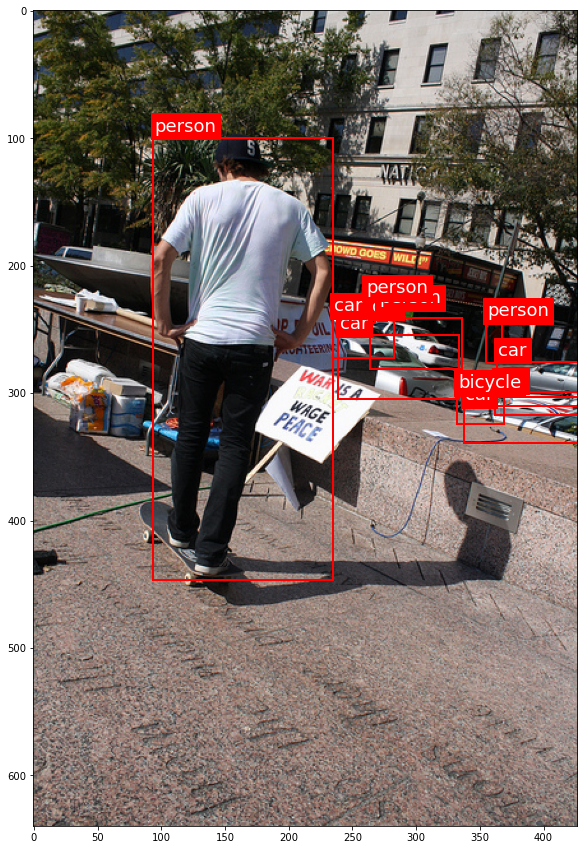

In [21]:
img_json = trainImages[np.random.randint(0, len(trainImages))]
img = cv.imread(os.path.join(TRAIN_DIR, img_json['file_name']))

ground_truths = []

annIds = cocoTrain.getAnnIds(img_json['id'], catIds=catTrainIds, iscrowd=None)
anns   = cocoTrain.loadAnns(annIds)

fig, ax = plt.subplots()

# visualize an image
img = Image.open(os.path.join(TRAIN_DIR, img_json['file_name']))

# visualize bbox im image
for ann in anns:
    ground_truth = {}

    bbox = ann['bbox']
    name_cat = cat_index_to_name[ann['category_id']]

    # extract bbox coordinates
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    ground_truth["bbox"] = [x, y, w, h]
    ground_truth["label_name"] = name_cat
    ground_truths.append(ground_truth)

    # add text and bbox
    plt.text(x+1, y-5, name_cat,fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
    bb = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bb)

ax.imshow(img)


# Detect

In [72]:
yolo_sets              = YoloConfig(YOLOV3_CFG, YOLOV3_WEIGHTS, subClass=['person'])
yolo_sets_with_gpu     = YoloConfig(YOLOV3_CFG, YOLOV3_WEIGHTS, subClass=['person'], active_gpu=True)

yolo_detector          = objectDetectorYolo(yolo_config=yolo_sets)
yolo_detector_with_gpu = objectDetectorYolo(yolo_config=yolo_sets_with_gpu)

set gpu


In [88]:
img_js_rand =  trainImages[np.random.randint(0, len(trainImages))]
yolo_detector.detect_objects(img_js_rand, show_detect_image=False)
yolo_detector_with_gpu.detect_objects(img_js_rand, show_detect_image=False)

inference time 0.3767857551574707
inference time 0.28813767433166504


In [54]:
yolo_sets              = YoloConfig(YOLOV4_CFG, YOLOV4_WEIGHTS, subClass=['person'])
yolo_sets_with_gpu     = YoloConfig(YOLOV4_CFG, YOLOV4_WEIGHTS, subClass=['person'], active_gpu=True)

yolo_detector          = objectDetectorYolo(yolo_config=yolo_sets)
yolo_detector_with_gpu = objectDetectorYolo(yolo_config=yolo_sets_with_gpu)

set gpu


In [71]:
img_js = img_json.copy()
yolo_detector.detect_objects(img_js, show_detect_image=False)
yolo_detector_with_gpu.detect_objects(img_js, show_detect_image=False)

inference time 0.36618542671203613
inference time 0.3414938449859619


# YOLOv5

In [90]:
net = cv.dnn.readNetFromONNX('yolov5s.onnx')


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\onnx\onnx_importer.cpp:194: error: (-5:Bad argument) Can't read ONNX file: yolov5s.onnx in function 'cv::dnn::dnn4_v20211220::ONNXImporter::ONNXImporter'


In [92]:
!git clone https://github.com/ultralytics/YOLOv5

Cloning into 'YOLOv5'...


In [114]:
!pip install ultralytics --user

In [116]:
!python export.py --weights models/YOLOv5s.pt --include onnx

export: data=C:\Users\QUOCHUNGTRAN\Desktop\repos\ML_projects\Digikam_benchmark_object_detection_algo\YOLOv5\data\coco128.yaml, weights=['models/YOLOv5s.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5  v7.0-185-g2334aa7 Python-3.9.7 torch-1.11.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

PyTorch: starting from models\YOLOv5s.pt with output shape (1, 25200, 85) (14.1 MB)

ONNX: starting export with onnx 1.14.0...
ONNX: export failure  0.0s: Unsupported ONNX opset version: 17


In [101]:
!cd YOLOv5 # Install dependencies.
!pip install -r requirements.txt
!pip install onnx



# Download .pt model.
!wget https://github.com/ultralytics/YOLOv5/releases/download/v6.1/YOLOv5s.pt
 
%cd .. # Export to ONNX.
!python export.py --weights models/YOLOv5s.pt --include onnx
 


The system cannot find the path specified.


     -------------------------------------- 184.3/184.3 kB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 77.1/77.1 kB 1.4 MB/s eta 0:00:00
     -------------------------------------- 611.8/611.8 kB 2.4 MB/s eta 0:00:00
  Using cached setuptools-68.0.0-py3-none-any.whl (804 kB)
     -------------------------------------- 62.7/62.7 kB 134.6 kB/s eta 0:00:00
  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
     ---------------------------------------- 38.2/38.2 MB 2.8 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.0.4
    Uninstalling setuptools-58.0.4:
      Successfully uninstalled setuptools-58.0.4
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:


      Successfully uninstalled numpy-1.23.5
  Rolling back uninstall of numpy
  Moving to c:\users\quochungtran\anaconda3\lib\site-packages\numpy-1.23.5.dist-info\
   from C:\Users\QUOCHUNGTRAN\anaconda3\Lib\site-packages\~umpy-1.23.5.dist-info
  Moving to c:\users\quochungtran\anaconda3\lib\site-packages\numpy\__config__.py
   from C:\Users\QUOCHUNGTRAN\AppData\Local\Temp\pip-uninstall-5ribkjqe\__config__.py
  Moving to c:\users\quochungtran\anaconda3\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\QUOCHUNGTRAN\AppData\Local\Temp\pip-uninstall-5ribkjqe\__init__.cython-30.pxd
  Moving to c:\users\quochungtran\anaconda3\lib\site-packages\numpy\__init__.pxd
   from C:\Users\QUOCHUNGTRAN\AppData\Local\Temp\pip-uninstall-5ribkjqe\__init__.pxd
  Moving to c:\users\quochungtran\anaconda3\lib\site-packages\numpy\__init__.py
   from C:\Users\QUOCHUNGTRAN\AppData\Local\Temp\pip-uninstall-5ribkjqe\__init__.py
  Moving to c:\users\quochungtran\anaconda3\lib\site-packages\numpy\__


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\QUOCHUNGTRAN\\anaconda3\\Lib\\site-packages\\numpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



[WinError 2] The system cannot find the file specified: '.. # Export to ONNX.'
c:\Users\QUOCHUNGTRAN\Desktop\repos\ML_projects\Digikam_benchmark_object_detection_algo\YOLOv5


'wget' is not recognized as an internal or external command,
operable program or batch file.
Traceback (most recent call last):
  File "c:\Users\QUOCHUNGTRAN\Desktop\repos\ML_projects\Digikam_benchmark_object_detection_algo\YOLOv5\export.py", line 71, in <module>
    from models.yolo import ClassificationModel, Detect, DetectionModel, SegmentationModel
  File "c:\Users\QUOCHUNGTRAN\Desktop\repos\ML_projects\Digikam_benchmark_object_detection_algo\YOLOv5\models\yolo.py", line 24, in <module>
    from models.common import *
  File "c:\Users\QUOCHUNGTRAN\Desktop\repos\ML_projects\Digikam_benchmark_object_detection_algo\YOLOv5\models\common.py", line 28, in <module>
    from utils.dataloaders import exif_transpose, letterbox
  File "c:\Users\QUOCHUNGTRAN\Desktop\repos\ML_projects\Digikam_benchmark_object_detection_algo\YOLOv5\utils\dataloaders.py", line 31, in <module>
    from utils.augmentations import (Albumentations, augment_hsv, classify_albumentations, classify_transforms, copy_paste

In [94]:
# Download the file.
import files
files.download('yolo_settings/YOLOv5s.onnx')

ModuleNotFoundError: No module named 'files'